a) visulization

In [1]:
from MNIST_dataloader import *
from matplotlib import pyplot as plt
import numpy as np

#import os 
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # avoid kernel shutting down

data_loc = 'Datasets' #change the datalocation to something that works for you
batch_size = 64
    
# get dataloader
train_loader, val_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
# get some examples
examples = enumerate(test_loader)
batch_idx, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9

In [3]:
print('train:', len(train_loader),'val:', len(val_loader), 'test:', len(test_loader))   

train: 782 val: 157 test: 157


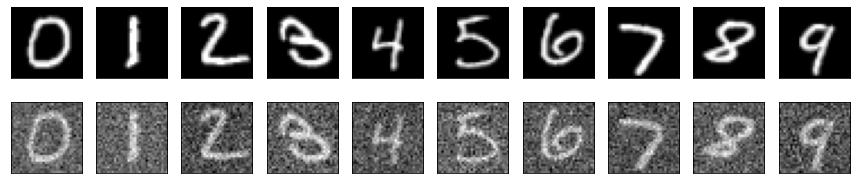

In [4]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
#plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [5]:
print('image size =',x_clean_example.size())

image size = torch.Size([64, 1, 32, 32])


b) network

In [6]:
import torch.nn as nn
import torch

dtype = torch.float32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device) # check device type


cuda:0


In [7]:
# model construction
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(32*32,200),
            nn.Linear(200,200),
            nn.Linear(200,10)
        )

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.layer(x)
        return x

In [33]:
# model construction
class Denoise_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(32*32,16*16),
            nn.Linear(16*16,8*8),
            nn.Linear(8*8,16*16),
            nn.Linear(16*16,32*32),
        )

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.layer(x)
        return x

In [34]:
import torch.optim as optim
import torch.nn.functional as F

# model
def build_model(model):
    model = model
    model.to(device)
    return model

# train
def train(model,optimizer,criterion,epochs):

    running_loss = 0.0
    train_loss =[]
    val_loss = []

    for epoch in range(epochs):
        for batch_idx, (clean_, noise_, label_) in enumerate(train_loader):
            model.train()  # put model to training mode
            if torch.cuda.is_available():
                clean_ = clean_.view(clean_.shape[0],-1).cuda()
                noise_ = noise_.view(clean_.shape[0],-1).cuda()
                label_ = label_.cuda()
            clean_ = clean_.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            noise_ = noise_.to(device=device, dtype=dtype)
            label_ = label_.to(device=device, dtype=torch.long)

            scores = model(noise_)
            loss = criterion(scores,clean_)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()   

            running_loss += loss.item()

            if batch_idx % 200 == 199 and epoch % 5 == 4:
                print('[epoch: %d, interation: %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 200))
                running_loss = 0.0
                
    # for _, (clean_, noise_, label_) in enumerate(val_loader):
    #     if torch.cuda.is_available():
    #         clean_ = clean_.cuda()
    #         noise_ = noise_.cuda()
    #         label_ = label_.cuda()
    #     outputs = model(noise_)
    #     _, predicted = torch.max(outputs,dim=1)
    #     acc += (label_ == predicted).sum().item()
    #     total += label_.shape[0]
    # print('Val accuracy: %d %%' % (100 * acc / total))

def test(dataloader,model):
    acc = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            clean_, noise_, label_ = data
            if torch.cuda.is_available():
                clean_ = clean_.cuda()
                noise_ = noise_.cuda()
                label_ = label_.cuda()
            outputs = model(noise_)
            _, predicted = torch.max(outputs,dim=1)
            acc += (label_ == predicted).sum().item()
            total += label_.shape[0]
    print('Accuracy: %d %%' % (100 * acc / total))
             

In [35]:
test(test_loader,Denoise_autoencoder().cuda())


Accuracy: 0 %


In [37]:
learning_rate = 1e-2
autoencoder = build_model(Denoise_autoencoder())
optimizer = optim.SGD(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train(autoencoder, optimizer, criterion, 20)

[epoch: 5, interation:   200] loss: 4.415
[epoch: 5, interation:   400] loss: 0.217
[epoch: 5, interation:   600] loss: 0.216
[epoch: 10, interation:   200] loss: 3.600
[epoch: 10, interation:   400] loss: 0.192
[epoch: 10, interation:   600] loss: 0.191
[epoch: 15, interation:   200] loss: 3.096
[epoch: 15, interation:   400] loss: 0.163
[epoch: 15, interation:   600] loss: 0.162
[epoch: 20, interation:   200] loss: 2.660
[epoch: 20, interation:   400] loss: 0.142
[epoch: 20, interation:   600] loss: 0.141


In [48]:
prediction = autoencoder(x_noisy_example.cuda())
prediction = torch.reshape(prediction,(prediction.shape[0],1,32,32)).detach().cpu()

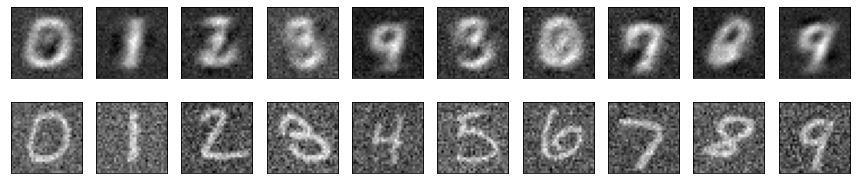

In [49]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(prediction[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
#plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [31]:
print('test set(no activation):')
test(test_loader,autoencoder)

test set(no activation):
Accuracy: 0 %


In [32]:
print('training set(no activation):')
test(train_loader,autoencoder)

training set(no activation):
Accuracy: 0 %


c) activation

In [44]:
def Relu(x):
	a = torch.zeros_like(x)
	return torch.max(x, a)

Text(0, 0.5, 'y')

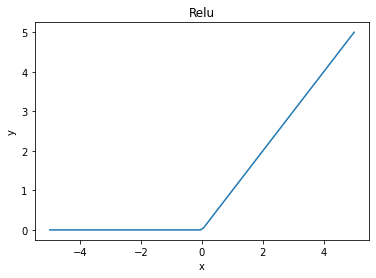

In [184]:
a_x_np = np.linspace(-5,5,100)
a_x = torch.from_numpy(a_x_np)
a_y = Relu(a_x)
plt.plot(a_x,a_y)
plt.title('Relu')
plt.xlabel('x')
plt.ylabel('y')

In [42]:
class Activation(nn.Module):
    def __init__(self):
        super().__init__()
        self.ly1 = nn.Linear(32*32,16*16)
        self.ly2 = nn.Linear(16*16,8*8)
        self.ly3 = nn.Linear(8*8,16*16)
        self.ly4 = nn.Linear(16*16,32*32)    

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.ly1(x)
        x = Relu(x)
        x = self.ly2(x)
        x = Relu(x)
        x = self.ly3(x)
        x = Relu(x)
        x = self.ly4(x)
        return x


In [45]:
learning_rate = 1e-2
activation_model = build_model(Activation())
optimizer = optim.SGD(activation_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train(activation_model, optimizer, criterion, 20)

[epoch: 5, interation:   200] loss: 5.119
[epoch: 5, interation:   400] loss: 0.221
[epoch: 5, interation:   600] loss: 0.223
[epoch: 10, interation:   200] loss: 3.874
[epoch: 10, interation:   400] loss: 0.219
[epoch: 10, interation:   600] loss: 0.219
[epoch: 15, interation:   200] loss: 3.764
[epoch: 15, interation:   400] loss: 0.208
[epoch: 15, interation:   600] loss: 0.208
[epoch: 20, interation:   200] loss: 3.496
[epoch: 20, interation:   400] loss: 0.190
[epoch: 20, interation:   600] loss: 0.189


In [52]:
prediction_activation = activation_model(x_noisy_example.cuda())
prediction_activation = torch.reshape(prediction_activation,(prediction_activation.shape[0],1,32,32)).detach().cpu()

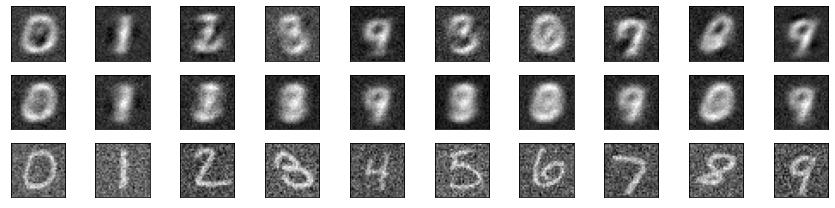

In [57]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(3,10,i+1)
        plt.imshow(prediction[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])


        plt.subplot(3,10,i+11)
        plt.imshow(prediction_activation[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3,10,i+21)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
#plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [198]:
print('test set(with Relu()):')
test(test_loader,activation_model)

test set(with Relu()):
Accuracy: 94 %


In [197]:
print('training set(with Relu()):')
test(train_loader,activation_model)

training set(with Relu()):
Accuracy: 98 %
